# Working with Branch Versioning

Branch versioning is the mechanism behind long transaction editing for web feature layers (feature services). Enabling the Version Management capability facilitates the creation of named versions and version management. Editors can then work with their own named version in the web feature layer, update the data, and reconcile and post their changes with the default version when finished.

This notebook will demonstrate some common methods for administering and edting with branch versioned feature services.

In [3]:
from arcgis.gis import GIS
from arcgis.features import FeatureLayerCollection

In [3]:
gis = GIS(profile="your_enterprise_profile")

#### Access the VersionManager object from a Feature Layer Collection

A feature service containing a collection of one or more feature layers is a `Feature Layer Collection`. If the feature service is published with the **Version Management** option, the feature layer collection will have a property called `versions` containing the `VersionManager` object.

<Item title:"BranchVersioned_FLC" type:Feature Layer Collection owner:api_data_owner>
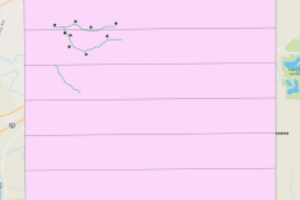

In [10]:
# Version Manager from FeatureLayerCollection
item = gis.content.search("BranchVersioned_FLC")
feature_layer_item = [i for i in item if i.type == "Feature Service"][0]
feature_layer_item

In [14]:
feature_layer_collection = FeatureLayerCollection(feature_layer_item.url, gis)
feature_layer_collection.layers

[<FeatureLayer url:"https://example.server.com/server/rest/services/BranchVersioned_FLC/FeatureServer/0">,
 <FeatureLayer url:"https://example.server.com/server/rest/services/BranchVersioned_FLC/FeatureServer/1">,
 <FeatureLayer url:"https://example.server.com/server/rest/services/BranchVersioned_FLC/FeatureServer/2">]

In [15]:
flc_version_manager = feature_layer_collection.versions
flc_version_manager

< VersionManager @ https://example.server.com/server/rest/services/BranchVersioned_FLC/VersionManagementServer >

### List branch versions

`VersionManager.all` will return all branch versions

In [16]:
version_manager.all

[<Version sde.DEFAULT @ {BD3F4817-9A00-41AC-B0CC-58F78DBAE0A1}>,
 <Version API_DATA_OWNER.editor1 @ {E600C422-341B-4B34-BF77-1986EBDCECDA}>]

## Find branch versions

### VersionManager.get()
Use `VersionManager.get(<version name string>, <mode>)` to access the `Version` object. 
- Set the mode to start a `read` session or an `edit` session.
- Using the context manager will help manage starting and stopping the edit session.

In [19]:
with version_manager.get("API_DATA_OWNER.editor1", None) as version:
    print(version.properties.versionName)

API_DATA_OWNER.editor1


### VersionManager.get_by_name()
Use `VersionManager.get_by_name(<version owner string>, <version name string>, <mode>) to access a `Version` object.

The `get_by_name` method uses the 'versionInfos` endpoint and can be much faster at retrieving a specific version when there is a large quantity of branch versions to consider.

In [21]:
with version_manager.get_by_name("API_DATA_OWNER", "editor1", None) as version:
    print(version.properties.versionName)

API_DATA_OWNER.editor1


## Creating Branch Versions

Create one or more branch versions with `VersionManager.create()`

In [82]:
versions = [
    {"name": "workplan_a123", "permission": "public", "description": "Version for workplan A123"},
    {"name": "workplan_b456", "permission": "public", "description": "Version for workplan A123"},
    {"name": "workplan_c789", "permission": "public", "description": "Version for workplan A123"},
]

for version in versions:
    new_version = version_manager.create(**version)
    print("Created version:", new_version["versionInfo"]["versionName"])

version_manager.all

Created version: ARCGIS_PYTHON.workplan_a123
Created version: ARCGIS_PYTHON.workplan_b456
Created version: ARCGIS_PYTHON.workplan_c789


[<Version sde.DEFAULT @ {BD3F4817-9A00-41AC-B0CC-58F78DBAE0A1}>,
 <Version API_DATA_OWNER.editor1 @ {E600C422-341B-4B34-BF77-1986EBDCECDA}>,
 <Version ARCGIS_PYTHON.workplan_a123 @ {7C185974-A8C7-492E-8D5F-F6C43DAE1113}>,
 <Version ARCGIS_PYTHON.workplan_b456 @ {9340D706-4861-4B43-A012-20AF82DF1AB4}>,
 <Version ARCGIS_PYTHON.workplan_c789 @ {212EA99C-B7D1-4C39-A42D-9689BCA43849}>]

## Branch Versioning Edit Sessions
A branch versioning edit session is the act of obtaining shared and exclusive locks on the feature class to prevent corruption in the branch version. Calling `version.startReading` will set a shared lock on the version which prevents another session from obtaining an exclusive lock. Other sessions can still access the version as read-only. Calling `version.startEditing` will set the exclusive lock which will prevent read access and write access to the version.

Keeping track of where one is within the edit sessions is made simple with a built in context manager. Use the `mode` parameter in the `VersionManager.get` call to set the initial `read` session. Alter the mode within the context manager to set the `edit` session.

In [31]:
with version_manager.get("ARCGIS_PYTHON.workplan_c789", mode="read") as version:
    print("Read lock initiated from function:")
    print("\tHas read lock:", version.properties["isBeingRead"])
    print("\tHas edit lock:", version.properties["isBeingEdited"])

    version.mode = "edit"

    print("Edit lock initiated from mode setter:")
    print("\tHas read lock:", version.properties["isBeingRead"])
    print("\tHas edit lock:", version.properties["isBeingEdited"])

print("Lock status after exiting context manager:")
print("\tHas read lock:", version.properties["isBeingRead"])
print("\tHas edit lock:", version.properties["isBeingEdited"])

Read lock initiated from function:
	Has read lock: True
	Has edit lock: False
Edit lock initiated from mode setter:
	Has read lock: False
	Has edit lock: True
Lock status after exiting context manager:
	Has read lock: False
	Has edit lock: False


Alternately, call `start_reading` and `start_editing` from a `Version`. Remember to call `stop_editing` and `stop_reading` when finished.

```python
version = version_manager.get("ARCGIS_PYTHON.workplan_c789", mode=None)
version.start_reading()
version.start_editing()

# Do some work

version.stop_editing()
version.stop_reading()
```

### Editing Branch Versioned Layers

The `Version` object has a method, `Version.edit` that allows one to pass in adds, updates and/or deletes.

https://developers.arcgis.com/python/latest/api-reference/arcgis.features.managers.html#arcgis.features._version.Version.edit

In [84]:
from arcgis.features import FeatureSet
adds = {"features":[
         {
            "attributes":{
               "Jurisdiction":"Rigby",
               "Height": 10.5,
            },
            "geometry":{
               "x":-8911900.3001000006,
               "y":5170534.9993999973,
               "spatialReference":{
                  "wkid":102100,
               }
            }
         }
      ]}
feature = FeatureSet.from_dict(adds)

target_version_name = "ARCGIS_PYTHON.workplan_b456"
feature_layer = [l for l in feature_layer_collection.layers if l.properties.name == "ObservationTowers"][0]
initial_rows = feature_layer.query("1=1", gdb_version=target_version_name)
print("Initial rows:", len(initial_rows))

with version_manager.get(target_version_name, mode="read") as version:
    version.mode = "edit"
    
    version.edit(feature_layer, adds=feature)
    version.save_edits = True
    print("New row added...")
    
new_feature = feature_layer.query("Jurisdiction = 'Rigby' AND height = 10.5", gdb_version=version.properties["versionName"])
new_feature.features[0].attributes
    

Initial rows: 9
New row added...


{'OBJECTID': 414,
 'Jurisdiction': 'Rigby',
 'Height': 10.5,
 'GlobalID': '{F09308DB-8B9F-4B0C-82FD-FA597186671F}',
 'created_user': 'arcgis_python',
 'created_date': 1751664384000,
 'last_edited_user': 'arcgis_python',
 'last_edited_date': 1751664384000}

## Find Version Differences

The differences method allows you to view differences between the current version and the default version. The two versions can be compared to check for the multiple conditions.

https://developers.arcgis.com/python/latest/api-reference/arcgis.features.managers.html#arcgis.features._version.Version.differences

In [87]:
target_version_name = "ARCGIS_PYTHON.workplan_b456"
observation_towers_layerid = feature_layer.properties.id
observation_towers_layerid
with version_manager.get(target_version_name, "read") as version:
    diff = version.differences(
        result_type="features", layers=[observation_towers_layerid], future=False
    )
diff

{'features': [{'layerId': 0,
   'inserts': [{'attributes': {'OBJECTID': 414,
      'Jurisdiction': 'Rigby',
      'Height': 10.5,
      'GlobalID': '{F09308DB-8B9F-4B0C-82FD-FA597186671F}',
      'created_user': 'arcgis_python',
      'created_date': 1751664384000,
      'last_edited_user': 'arcgis_python',
      'last_edited_date': 1751664384000},
     'geometry': {'x': -8911900.3001, 'y': 5170534.999399997}}]}],
 'success': True}

## Reconcile and Post Edits
Use the `Version` object to reconcile and post edits to the Default version. Use the `rows` argument to pass in a subset of features to post to Default. Passing in a subset of features is known as a "partial post".

https://developers.arcgis.com/python/latest/api-reference/arcgis.features.managers.html#arcgis.features._version.Version.post

In [89]:
target_version_name = "ARCGIS_PYTHON.workplan_a123"
with version_manager.get(target_version_name, "read") as version:
    version.mode = "edit"
    result = version.reconcile(
        end_with_conflict=True,
        conflict_detection="byAttribute",
        with_post=False,
        future=False,
    )

    if result.get("success"):
        did_post = version.post(rows=None, future=False)
        print(did_post)

True


In [91]:
rows_in_default = feature_layer.query("1=1")
len(rows_in_default)

10

## Delete Versions
After successfully reconciling and posting edits to Default, the version(s) can be deleted.

In [92]:
version_manager = VersionManager(version_management_server_url, gis)
for version in version_manager.all:
    if "workplan" in version.properties["versionName"]:
        version.delete()
        print("Deleted:", version.properties["versionName"])

Deleted: ARCGIS_PYTHON.workplan_a123
Deleted: ARCGIS_PYTHON.workplan_b456
Deleted: ARCGIS_PYTHON.workplan_c789
